### Global wet bulb temperature vs web bult temperature
Global wet bult temperature is calculated by Andy reference to: https://github.com/QINQINKONG/PyWBGT/tree/v1.0.0

#### 0 setup
 - 0.1 Crop hourly ERA5 to CONUS404 domain 
 - 0.2 Compute ERA5 WBGT daily mean and Max
#### 1 Climatology
 - 1.1 Mean
 - 1.2 Annual maximum  mean
#### 2 Trend: increase over 1980-2020 (linear regression)  
 - 2.1) Annual mean increase over 40 years
 - 2.2) Annual maximum increase  over 40 year
#### 3 Trend: number of days exceed Black Flag days over 1980-2019 using linear regression
 - 3.1) Calculate annual number of days exceed TBF
 - 3.2) Calculate trend using xarray da.polyfit
 - 3.3) Calculate P-value (<0.05 significant)
 - 3.4) Plotting the increase of number of days exceed P95 over 1980-2020 using linear regression ( p -value less than 0.05 hatched)
#### 4) Trend: number of days exceed Black Flag days for each hour of the day
 - 4.1.1) number of days above TBF - ERA5
 - 4.1.2) number of days above TBF - WRF CONUS404 

Black Flag (WBGT index of 90F and above) <br>
https://www.hprc-online.org/physical-fitness/environmental-extremes/military-heat-flag-conditions-explained

In [2]:
import os.path
import numpy as np
import xarray as xr
import datetime
from calendar import monthrange
import scipy
import scipy.spatial.qhull as qhull
from scipy import stats

import matplotlib.pyplot as plt 
import pandas as pd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
# Interpolation functions from Andy
def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)


In [31]:
def ax_coastlines_country(ax_s):
    ax_s.coastlines(lw=1.5, resolution='110m')
    ax_s.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    ax_s.add_feature(cfeature.OCEAN, facecolor='white', zorder=1) 


def plot_cartopy_p3(lat_1d, lon_1d, data_1, lat_2d, lon_2d, data_2, data_d, title_s, vmin, vmax, nlevel, v_dif, cmap):
    fig = plt.figure(figsize=(22, 8))
    level_s = np.linspace(vmin, vmax, nlevel) 
    level_d = np.linspace(-1*v_dif, v_dif, 10) 
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    
    for nf in range(1,4):
        ax = fig.add_subplot(1, 3, nf, projection= ccrs.PlateCarree())
     
        # Set lat/lon bounding box and feature resolutions.
        ax.set_extent([-130, -60, 25, 50])
         
        if nf==1 :
            lat_n = lat_1d
            lon_n = lon_1d
            data_n = data_1
            levels = level_s
        elif nf == 2:
            lat_n = lat_2d
            lon_n = lon_2d
            data_n = data_2
            levels = level_s
        else:
            lat_n = lat_1d
            lon_n = lon_1d
            data_n = data_d
            levels = level_d
            vmax = v_dif
            vmin = -1*v_dif
             
        mm = plt.contourf(lon_n, lat_n, data_n, 
                      cmap = cmap[nf-1], extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
        
        ax.coastlines()
        ax_coastlines_country(ax)
        
        plt.colorbar(mm, orientation='horizontal', pad=0.05, extend='both')    
     
        gl = ax.gridlines(draw_labels=True)   
        gl.xlines = gl.ylines = False

        plt.title(title_s[nf-1], fontweight="bold",fontsize=14)
     

def plot_cartopy_hatches(lat_2d, lon_2d, data_2d, data_hat, title_s, vmin, vmax, nlevel, cmap):
    '''
    overlay terrain on top of plot_cartopy_2d
    '''
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(1, 1, 1, projection= ccrs.PlateCarree())

    levels = np.linspace(vmin, vmax, nlevel) 
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    mm = plt.contourf(lon_2d, lat_2d, data_2d, 
                      cmap = cmap, extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
    
    # hatching <0.05
    plt.contourf(lon_2d, lat_2d, data_hat, levels=[-99, 0.05, 99],
                    colors='none', hatches=['////', ''], linewidth=22 ) #, alpha=.5)
    ax.coastlines()
 
    ax.coastlines(lw=1.5, resolution='110m')
    ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')    
    
    gl = ax.gridlines(draw_labels=True)   
    gl.xlines = gl.ylines = False

    plt.title(title_s, fontweight="bold", fontsize=14)
    plt.show()

In [5]:
#### 1st filename of ERA5 and then WRF CONUS  
def plot_clim_p3(flnm_era5, flnm_wrf, vmin, vmax, n_level, vabs):
    if 'slope' in flnm_era5:
        color_1d = ['Reds', 'Reds', 'RdBu_r']
        with xr.open_dataset(flnm_era5) as ds_1:
            data_1 = ds_1.WBGT*(n_year-1)
            lat_1d = ds_1.latitude
            lon_1d = ds_1.longitude
    else:
        with xr.open_dataset(flnm_era5) as ds_1:
            color_1d = ['RdBu_r', 'RdBu_r', 'RdBu_r']
            data_1 = ds_1.WBGT.sel(time=slice(year_s, year_e)).mean(dim='time')     
            lat_1d = ds_1.latitude
            lon_1d = ds_1.longitude
     
    if 'slope' in flnm_wrf:
        with xr.open_dataset(flnm_wrf) as ds_2:
            data_2 = ds_2.GWBT*(n_year-1) 
            lat_wrf = ds_2.lat.values
            lon_wrf = ds_2.lon.values
    else:
        with xr.open_dataset(flnm_wrf) as ds_2:
            data_2 = ds_2.GWBT.sel(time=slice(year_s, year_e)).mean(dim='time')
            lat_wrf = ds_2.lat.values
            lon_wrf = ds_2.lon.values
    
    #interpolate WRF conus to ERA5 grid
    lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)
    points = np.array([lon_wrf.flatten(), lat_wrf.flatten()]).transpose()
    vtx, wts = interp_weights(points, np.append(lon_2d.flatten()[:,None], lat_2d.flatten()[:,None], axis=1)) 

    valuesi=interpolate(data_2.values.flatten(), vtx, wts)
    data_3 =  valuesi.reshape(lat_2d.shape[0], lat_2d.shape[1])
    data_d = (data_3 - data_1)
    # get rid of missing data of interpolated CONUS 404
    data_d = data_d.where(abs(data_d)<4)

    data_dif = xr.DataArray(data_d, 
                    coords={'latitude': ds_1['latitude'], 
                            'longitude': ds_1['longitude']},
                    dims=['latitude', 'longitude'])    

    
    title_1d = ['WBGT ERA5', 'GWBT CONUS404', 'CONUS404-ERA5']
    plot_cartopy_p3(lat_1d, lon_1d, data_1,lat_wrf, lon_wrf, data_2, data_dif, title_1d, vmin, vmax, n_level, vabs, color_1d)


#### 0) Setups

In [6]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
var_s = ['GWBT', 'WGBT']
n_var = len(var_s)


year_s = 1980
year_e = 2019
mon_e = 12

n_year = year_e - year_s + 1

# 1950-2021 (2020 is missing)
dir_era5 = '/glade/campaign/mmm/c3we/prein/ERA5/WBGT/'

# 1980 - 202209  (202110 is missing)
dir_conus = '/glade/campaign/mmm/c3we/ESTCP/CONUS404/GWBT/'

# comparison  /glade/campaign/mmm/c3we/mingge/DOD/GWBT_DAILY
flnm = dir_conus + 'GWBT_202009_CONUS404.nc'
with xr.open_dataset(flnm) as ds:
    print(flnm)
    lat_s = ds.lat.min()
    lat_e = ds.lat.max()
    lon_s = ds.lon.min()
    lon_e = ds.lon.max()
    lat_conus = ds.lat.values
    lon_conus = ds.lon.values
    n_lat_conus = ds.lat.shape[0]
    n_lon_conus = ds.lat.shape[1]
    print('n conus = ', n_lat_conus, n_lon_conus)
    print(lat_s, lat_e, lon_s, lon_e)

flnm = dir_era5 + 'WBGT_ERA5_2019.nc'
with xr.open_dataset(flnm) as ds:
    print(flnm)
    lat_era5 = ds.latitude.sel(latitude=slice(lat_e, lat_s)).values
    lon_era5 = ds.longitude.sel(longitude=slice(lon_s, lon_e)).values
    n_lat = len(lat_era5)
    n_lon = len(lon_era5)
    print('n ERA5 = ', n_lat, n_lon)

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


/glade/campaign/mmm/c3we/ESTCP/CONUS404/GWBT/GWBT_202009_CONUS404.nc
n conus =  1015 1367
<xarray.DataArray 'lat' ()>
array(17.64730835) <xarray.DataArray 'lat' ()>
array(57.34341812) <xarray.DataArray 'lon' ()>
array(221.26864624) <xarray.DataArray 'lon' ()>
array(302.93136597)
/glade/campaign/mmm/c3we/prein/ERA5/WBGT/WBGT_ERA5_2019.nc
n ERA5 =  159 326


#### 0.1 ) crop hourly ERA5 daily WBGT to speed up

In [7]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_HOURLY/'

year_s = 1950
year_e = 2019
 
is_finished = True

if is_finished:
    print('finished data is under:', dir_o)
else:
    for year in range(year_s, year_e+1, 1):
        StartDay = datetime.datetime(year, 1, 1,  0)
        EndDay   = datetime.datetime(year, 12, 31, 0)
        TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
     
        flnm  = dir_era5 + 'WBGT_ERA5_' + str(year) + '.nc'
        with xr.open_dataset(flnm) as ds:
            print(flnm)
            gwbt_3d = ds.WBGT.sel(latitude=slice(lat_e, lat_s),longitude=slice(lon_s, lon_e)).values
            # by default, order = 'C': with the last axis index changing fastest
            gwbt_4d = gwbt_3d.reshape(int(gwbt_3d.shape[0]/24), 24, gwbt_3d.shape[1], gwbt_3d.shape[2])
         
        for month in range(1, 13):
            yyyymm_s = str(year*100 + month) 
            flnm_o = dir_o + 'WBGT_' + yyyymm_s + '_ERA5_hourly.nc'
             
            if os.path.isfile(flnm_o):
                print(flnm_o, 'exist')
            else:   
                # match those MONTHS
                iTime = np.isin(TimeDD.month, month) 
                #print(TimeDD[iTime])
                data_4d = gwbt_4d[iTime] 
                 
                data_xr = xr.DataArray(data_4d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5, 
                            'hour': range(1, 24+1),
                            'day': range(1, data_4d.shape[0]+1)},
                                   
                    dims=['day', 'hour', 'latitude', 'longitude'],
                    attrs = {'script':'Ming Ge: wgbt_wrf_era5_cmp.ipynb' })
                     
                data_xr = data_xr.rename('WBGT') 
                print(flnm_o)
                data_xr.to_netcdf( path = flnm_o)  

finished data is under: /glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_HOURLY/


- 0.2) Compute ERA5 daily WBGT, Max

In [8]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_DAILY/'

year_s = 1950
year_e = 2019
 
is_mean = True
is_finished = True

if is_finished:
    print(dir_o)
else:
  for year in range(year_s, year_e+1, 1):
    StartDay = datetime.datetime(year, 1, 1,  0)
    EndDay   = datetime.datetime(year, 12, 31, 0)
    TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
     
    flnm  = dir_era5 + 'WBGT_ERA5_' + str(year) + '.nc'
    with xr.open_dataset(flnm) as ds:
        print(flnm)
         
        gwbt_3d = ds.WBGT.sel(latitude=slice(lat_e, lat_s),longitude=slice(lon_s, lon_e)).values
        #print(lat_s, lat_e, lon_s, lon_e)
        #print(gwbt_3d.shape)
        # by default, order = 'C': with the last axis index changing fastest
        gwbt_4d = gwbt_3d.reshape(int(gwbt_3d.shape[0]/24), 24, gwbt_3d.shape[1], gwbt_3d.shape[2])
        if is_mean == True:
            mean_3d = np.mean(gwbt_4d, axis=1)
        else:
            mean_3d = np.max(gwbt_4d, axis=1)
        print(mean_3d.shape)
        
        for month in range(1, 13):
            yyyymm_s = str(year*100 + month)
            if is_mean == True:
                flnm_o = dir_o + 'WBGT_' + yyyymm_s + '_ERA5_daily.nc'
            else:
                flnm_o = dir_o + 'WBGT_' + yyyymm_s + '_ERA5_max.nc'
            if os.path.isfile(flnm_o):
                print(flnm_o, 'exist')
            else:   
                # match those MONTHS
                iTime = np.isin(TimeDD.month, month) 
                #print(TimeDD[iTime])
                data_3d = mean_3d[iTime] 
                
                print(flnm_o)
                data_xr = xr.DataArray(data_3d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5, 
                            'day': range(1, data_3d.shape[0]+1)},
                    dims=['day', 'latitude', 'longitude'],
                    attrs = {'script':'Ming Ge: wgbt_wrf_era5_cmp.ipynb' })
                     
                data_xr = data_xr.rename('WBGT') 
                data_xr.to_netcdf( path = flnm_o)                

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_DAILY/


- 1.0) Compute annual WGBT ERA5 data from daily data

In [9]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
is_mean = True  # True for Maximum

var_s = 'WBGT'

year_s = 1980
year_e = 2019
#year_s = year_e 
mon_e = 12

n_year = year_e - year_s + 1

is_first = True

if is_mean:
    flnm_o = dir_o + 'WBGT_ERA5_annual_mean.nc'
else:
    flnm_o = dir_o + 'WBGT_ERA5_annual_max.nc'
    
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
else:
    for year in range(year_s, year_e + 1):
        for month in range(1, mon_e + 1):
            if is_mean:
                flnm = dir_o + var_s + '_ERA5_DAILY/' + var_s + '_' + str(year)+ str(month).zfill(2) + '_ERA5_daily.nc'
            else:
                flnm = dir_o + var_s + '_ERA5_DAILY/' + var_s + '_' + str(year)+ str(month).zfill(2) + '_ERA5_max.nc'
            with xr.open_dataset(flnm) as ds:
                print(var_s,flnm)
                data_d = ds[var_s]
            
            # concatenate/append numpy data  
            if month == 1:
                data_y = data_d.copy()
                if is_first == True:
                    data_3d = np.zeros((n_year, data_y.shape[1], data_y.shape[2]))
                    is_first = False                     
            else:
                data_y = np.append(data_y, data_d, axis=0)
                
            if month == mon_e:
                if is_mean:
                    data_3d[year-year_s] = np.mean(data_y, axis=0)
                else:
                    data_3d[year-year_s] = np.amax(data_y, axis=0)
                        
        
            da = xr.DataArray(data = data_3d,
                          coords={'time': range(year_s, year_e + 1),
                                  'latitude': ds.latitude, 
                                  'longitude': ds.longitude}, 
                          dims=["time", "latitude", "longitude"],
                          attrs = {'script':'Ming Ge: wgbt_wrf_era5_cmp.ipynb' }   )
            
         
    # create and write out dataset 
    ds = da.to_dataset(name = var_s)         
    ds.to_netcdf(flnm_o)
    print(flnm_o)             

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_mean.nc exist


- 1.1 climatology  (of 1980-2019)

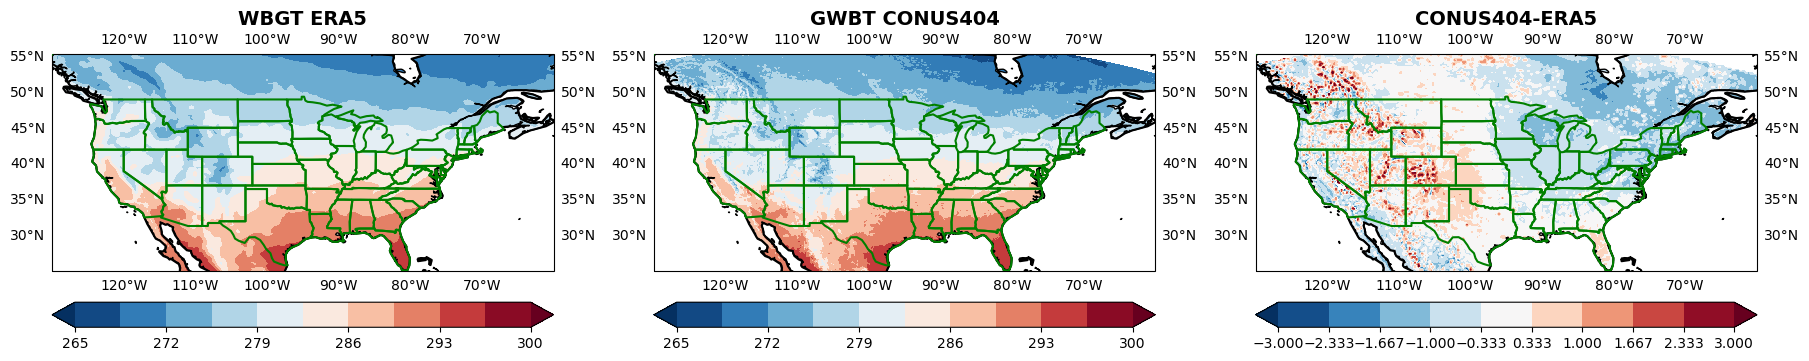

In [32]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
#### 1rs filename of ERA5 and then WRF CONUS  
plot_clim_p3(dir_o + 'WBGT_ERA5_annual_mean.nc', dir_o + 'GWBT_CONUS404_annual_mean.nc', 265, 300, 11, 3)

-  1.2) mean annual maximum (of 1980-2019)

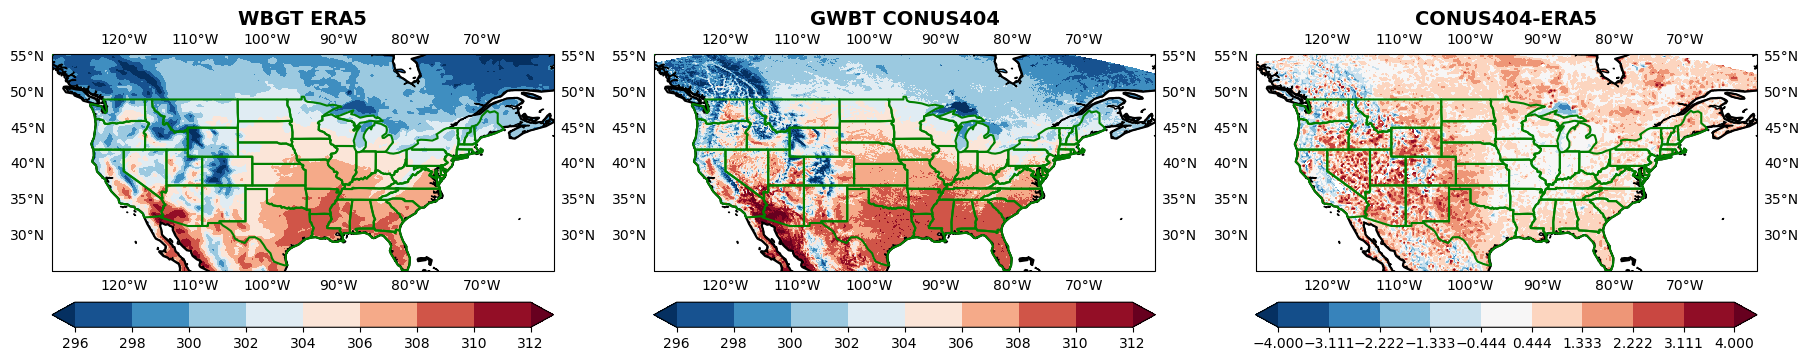

In [33]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
#### 1rs filename of ERA5 and then WRF CONUS  
plot_clim_p3(dir_o + 'WBGT_ERA5_annual_max.nc', dir_o + 'GWBT_CONUS404_annual_max.nc', 296, 312, 9, 4)

##### 2 Trend calculation

In [12]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
method = ['mean', 'max']
for nm in range(len(method)):
    flnm_i = dir_o + 'WBGT_ERA5_annual_' + method[nm] + '.nc'
    flnm_o = dir_o + 'WBGT_ERA5_annual_' + method[nm]+ '_slope.nc'
    
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        #with xr.open_dataset(flnm_o) as ds:
        #    print(var_s[nv],flnm_o)
        #    da = ds[var_s[nv]]
    else:
        with xr.open_dataset(flnm_i) as ds:
            print(ds,flnm_i)
            data_3d = ds['WBGT']
            n_year = data_3d.shape[0]
        
        slope_2d = np.zeros((n_lat, n_lon))  
        for ni in range(n_lat):
            print(ni)
            for nj in range(n_lon):
                slope_2d[ni, nj] = np.polyfit(range(data_3d.shape[0]), data_3d[:,ni, nj],1)[0]           
         
        da = xr.DataArray(data = slope_2d,
                          coords={'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=["latitude", "longitude"])
                    
        ds = da.to_dataset(name='WBGT')         
        ds.to_netcdf(flnm_o)
        print(flnm_o)      

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_mean_slope.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_max_slope.nc exist


- 2.1 Annual mean increase over 40 years

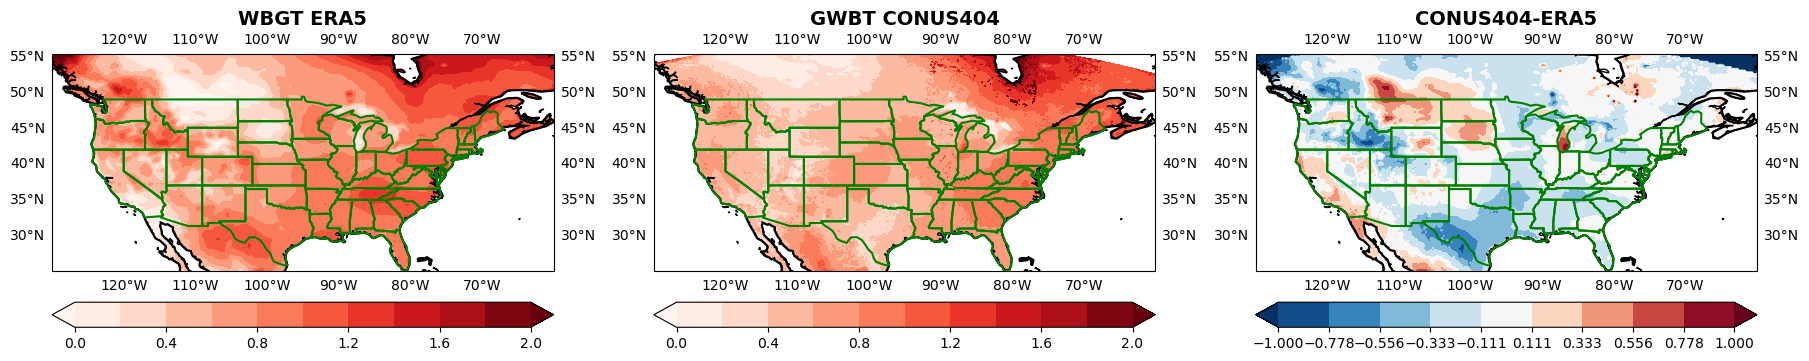

In [34]:
#### 1rs filename of ERA5 and then WRF CONUS  
plot_clim_p3(dir_o + 'WBGT_ERA5_annual_mean_slope.nc', dir_o + 'GWBT_CONUS404_annual_mean_slope.nc',  0, 2, 11, 1)

- 2.2) Annual maximum increase over 40 year

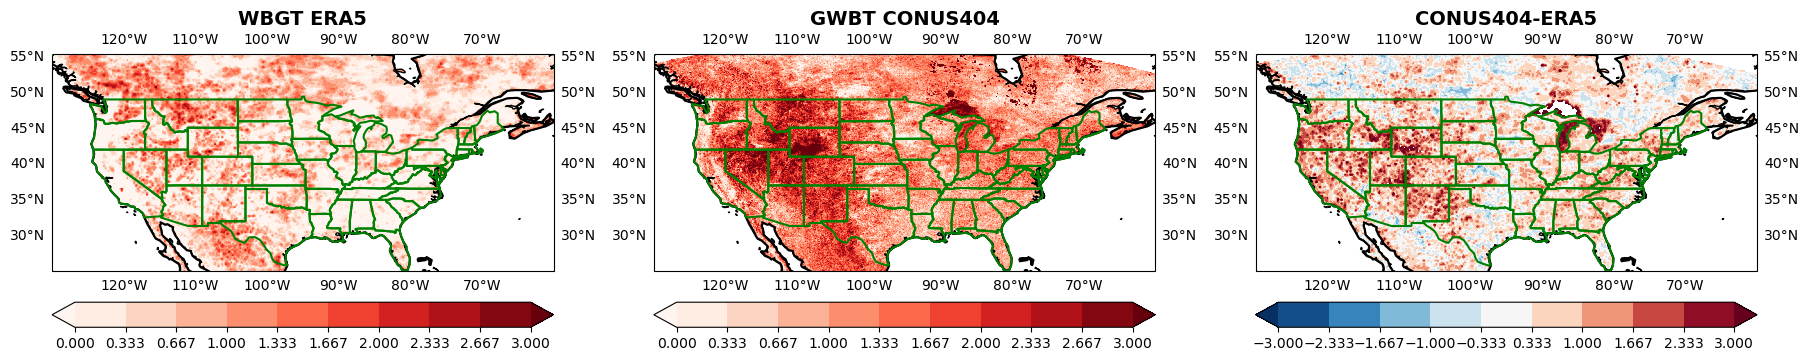

In [35]:
#### 1st filename of ERA5 and then WRF CONUS  
plot_clim_p3(dir_o + 'WBGT_ERA5_annual_max_slope.nc', dir_o + 'GWBT_CONUS404_annual_max_slope.nc',  0, 3, 10, 3)

#### 3) Black Flag TBF (WBGT index of 90F and above)

In [15]:
tbf = 305.372  # 90F -> K

n_month = 12
n_hour = 24

- 3.1.1) number of days above TBF: ERA5

In [16]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

var_s = 'WBGT'

flnm_o = dir_o + var_s + '_ERA5_annual_TBFday.nc'
    
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
else: 
    data_3d = np.zeros((n_year, n_lat, n_lon))
    dir_i = dir_o + var_s + '_ERA5_DAILY/'
    for year in range(year_s, year_e + 1):
        for month in range(1, mon_e + 1):
            flnm = dir_i + var_s + '_' + str(year)+ str(month).zfill(2) + '_ERA5_max.nc'
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_d = ds[var_s]
                # concatenate/append numpy data  
                if month == 1:
                    data_y = data_d.copy()               
                else:
                    data_y = np.append(data_y, data_d, axis=0)
                
                if month == mon_e:
                    data_y = data_y - tbf
                    data_3d[year-year_s] = np.sum(data_y > 0,  axis=0)
                    print(data_y.shape)
                    
    da = xr.DataArray(data = data_3d,
                    coords = {'time': range(year_s, year_e + 1),'latitude': ds.latitude, 'longitude': ds.longitude}, 
                    dims = ["time", "latitude", "longitude"])
            
        
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o)     
 

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday.nc exist


- 3.1.2) number of days above TBF: WRF

In [17]:
dir_i = '/glade/campaign/mmm/c3we/ESTCP/CONUS404/GWBT/'
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

flnm_o = dir_o + 'GWBT' + '_CONUS404_annual_TBFday.nc'
    
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
else: 
    data_3d = np.zeros((n_year, n_lat_conus, n_lon_conus))
    
    dir_i = dir_o + 'GWBT_DAILY/'
    for year in range(year_s, year_e + 1):
        for month in range(1, mon_e + 1):
            flnm = dir_i + 'GWBT_' + str(year)+ str(month).zfill(2) + '_CONUS404_max.nc'
            
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_d = ds['GWBT']
            
                # concatenate/append numpy data  
                if month == 1:
                    data_y = data_d.copy()               
                else:
                    data_y = np.append(data_y, data_d, axis=0)
                
                if month == mon_e:
                    data_y = data_y - tbf
                    data_3d[year-year_s] = np.sum(data_y >0,  axis=0)
                    print(data_y.shape)
                    
    da = xr.DataArray(data = data_3d,
                    coords = {'time': range(year_s, year_e + 1),'lat': ds.lat, 'lon': ds.lon}, 
                    dims = ["time", "y", "x"])
            
        
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o)     

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday.nc exist


- 3.2) Calculate trend using xarray da.polyfit

In [18]:
var_s = ['WBGT', 'GWBT']
model_s = ['ERA5', 'CONUS404']
var_ss = 'n_TBF'

for nv in range(n_var):
    flnm = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday.nc'
    flnm_o = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday_slope.nc'
     
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        with xr.open_dataset(flnm_o) as ds:
            print(var_ss,flnm_o)
            da = ds.polyfit_coefficients
    else:
        with xr.open_dataset(flnm) as ds:
            print(flnm)
            data_3d = ds[var_ss]
            trend = data_3d.polyfit(dim='time', deg=1)
            trend.to_netcdf(flnm_o)
            print(flnm_o)   

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_slope.nc exist
n_TBF /glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_slope.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_slope.nc exist
n_TBF /glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_slope.nc


- 3.3) Calculate P-value (<0.05 significant)

In [19]:
for nv in range(n_var):
    flnm_o = dir_o + var_s[nv] + '_' + model_s[nv] + '_TBFday_Pvalue.nc'
    flnm_i1 = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday.nc'
        
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
    else:
        with xr.open_dataset(flnm_i1) as ds:
            #print(ds)
            data_3d = ds[var_ss]
    
        pvalue_2d = np.zeros((data_3d.shape[1], data_3d.shape[2]))
        print(pvalue_2d.shape)
        for ni in range(data_3d.shape[1]):
            print(ni)
            for nj in range(data_3d.shape[2]):
                slope, intercept, r, pvalue_2d[ni,nj], se = stats.linregress(ds.time, data_3d[:, ni, nj])
                
        if var_s[nv] == 'GWBT':
            da = xr.DataArray(data = pvalue_2d,
                          coords={'lat': ds.lat, 'lon': ds.lon}, 
                          dims=["y", "x"])
            
        elif  var_s[nv] == 'WBGT':
            da = xr.DataArray(data = pvalue_2d,
                          coords={'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=[ "latitude", "longitude"])
        
        # create and write out dataset 
        ds = da.to_dataset(name = var_s[nv])         
        ds.to_netcdf(flnm_o)
        print(flnm_o)  

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_TBFday_Pvalue.nc exist
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_TBFday_Pvalue.nc exist


- 3.4)  Plotting the increase of number of days exceed TBF over 1980-2019 using linear regression ( p -value less than 0.05 hatched)

0 /glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_slope.nc
1 /glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_slope.nc
interpolate


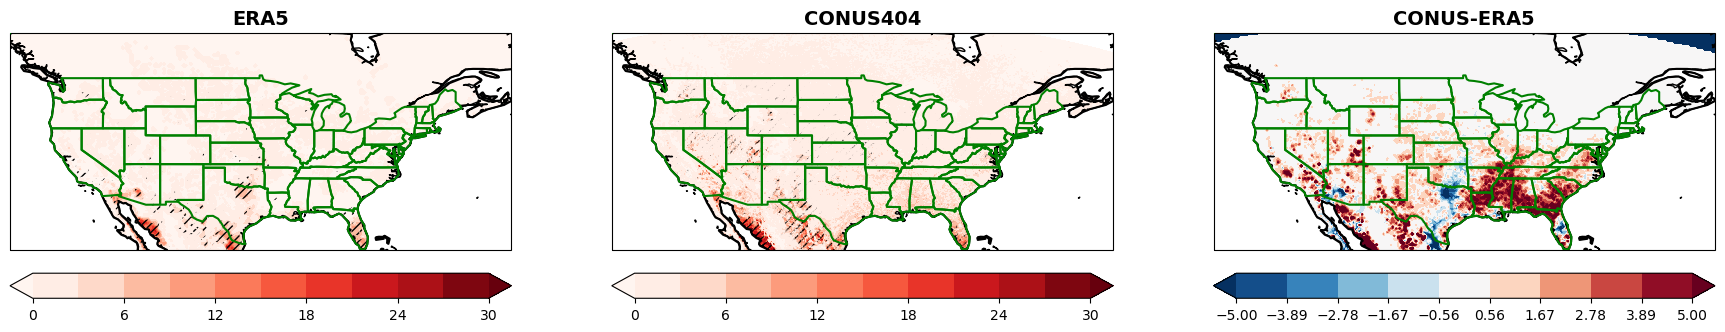

In [26]:
var_s = ['WBGT', 'GWBT']
model_s = ['ERA5', 'CONUS404']
var_ss = 'n_TBF'
fig = plt.figure(figsize=(22, 10))
vmin = 0
vmax = 30
n_level = 11
levels = np.linspace(vmin, vmax, n_level) 
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}

# A p -value less than 0.05 (typically ≤ 0.05) 
for nv in range(len(var_s)):
    ax = fig.add_subplot(1, 3, nv+1, projection= ccrs.PlateCarree())
    ax.set_extent([-130, -60, 25, 50])
    flnm = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday_slope.nc'
    print(nv, flnm)
    var_ss = 'n_' + var_s[nv]
    
    # read p_value which is used for hatching (0.05)
    flnm_i = dir_o + var_s[nv] + '_' + model_s[nv] + '_TBFday_Pvalue.nc'
    
    with xr.open_dataset(flnm_i) as dss:
        data_p = dss[var_s[nv]]
         
    with xr.open_dataset(flnm) as ds:
        da = ds['polyfit_coefficients'][0].values
    
    if var_s[nv] == 'GWBT':
        lat_2d = dss.lat.values
        lon_2d = dss.lon.values
        #plot_cartopy_hatches(dss.lat, dss.lon, da*(n_year-1), data_p, '# of days increased '+ var_s[nv], 0, 30, 11, 'Reds')
    else:
        lat_2d = dss.latitude.values
        lon_2d = dss.longitude.values
        #plot_cartopy_hatches(dss.latitude, dss.longitude, d
     
    mm = plt.contourf(lon_2d, lat_2d, da*(n_year-1), 
                      cmap = 'Reds', extend='both',
                      vmin = vmin, vmax = vmax, levels = levels,
                      transform=ccrs.PlateCarree())
    
    # hatching <0.05
    plt.contourf(lon_2d, lat_2d, data_p, levels=[-99, 0.05, 99],
                    colors='none', hatches=['////', '']) #, alpha=.5)
    ax.coastlines()
 
    ax.coastlines(lw=1.5, resolution='110m')
    ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
    plt.title(model_s[nv], fontweight="bold", fontsize=14)
     
    
    if nv == 0:
        da_0   = da
        lat_0  = lat_2d
        lon_0  = lon_2d

print('interpolate')        
#interpolate WRF conus to ERA5 (lat_0, lon_0) grid
lon_new, lat_new = np.meshgrid(lon_0, lat_0)
points = np.array([lon_2d.flatten(), lat_2d.flatten()]).transpose()
vtx, wts = interp_weights(points, np.append(lon_new.flatten()[:,None], lat_new.flatten()[:,None], axis=1)) 

value_0 = interpolate(da.flatten(), vtx, wts)
da_3  =  value_0.reshape(lat_new.shape[0], lat_new.shape[1])
da_d  = (da_3 - da_0)

# get rid of missing data of interpolated CONUS 404
da_d  = np.where(abs(da_d)<4, da_d, -99)
data_dif = xr.DataArray(da_d, 
                    coords={'latitude': lat_0, 
                            'longitude': lon_0},
                    dims=['latitude', 'longitude'])

ax = fig.add_subplot(1, 3, 3, projection= ccrs.PlateCarree())
ax.set_extent([-130, -60, 25, 50])
mm = plt.contourf(lon_new, lat_new, data_dif*(n_year-1), 
                      cmap = 'RdBu_r', extend='both',
                      vmin = -5, vmax = 5, levels=np.linspace(-5, 5, 10) ,
                      transform=ccrs.PlateCarree())
    
ax.coastlines() 
ax.coastlines(lw=1.5, resolution='110m')
ax.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
# mask ocean 
ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
plt.colorbar(mm, orientation='horizontal', pad=0.03, extend='both')
plt.title('CONUS-ERA5', fontweight="bold", fontsize=14)
plt.show()

#### 4) Trend: number of days exceed Black Flag days for each hour of the day
- 4.1.1) number of days above TBF - ERA5

In [21]:
var_s = 'WBGT'

year_s = 1980
year_e = 2019

flnm_o = dir_o + var_s + '_ERA5_annual_TBFday_hourly.nc'

if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
else: 
    data_4d = np.zeros((n_year, n_hour, n_lat, n_lon))
    dir_i = dir_o + var_s + '_ERA5_HOURLY/'
    for year in range(year_s, year_e + 1):
        for month in range(1, mon_e + 1):
            flnm = dir_i + var_s + '_' + str(year)+ str(month).zfill(2) + '_ERA5_hourly.nc'
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_d = ds[var_s]
                # concatenate/append numpy data  
                if month == 1:
                    data_y = data_d.copy()               
                else:
                    data_y = np.append(data_y, data_d, axis=0)
                
                if month == mon_e:
                    data_y = data_y - tbf
                    data_4d[year-year_s] = np.sum(data_y > 0,  axis=0)
                    print(data_y.shape)
                    
    da = xr.DataArray(data = data_4d,
                    coords = {'year': range(year_s, year_e + 1),
                              'hour': range(1, n_hour+1),
                              'latitude': ds.latitude, 
                              'longitude': ds.longitude}, 
                    dims = ["year", "hour", "latitude", "longitude"])
            
        
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o)     

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_hourly.nc exist


- 4.1.2) number of days above TBF - WRF CONUS404

In [22]:
dir_i = '/glade/campaign/mmm/c3we/ESTCP/CONUS404/GWBT/'
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

mon_e = 12
flnm_o = dir_o + 'GWBT' + '_CONUS404_annual_TBFday_hourly.nc'
    
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
else: 
    data_4d = np.zeros((n_year, n_hour, n_lat_conus, n_lon_conus))
    
    for year in range(year_s, year_e + 1):
        for month in range(1, mon_e + 1):
            flnm = dir_i + 'GWBT_' + str(year)+ str(month).zfill(2) + '_CONUS404.nc'
            
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                data_0 = ds['GWBT'].values
                data_d = data_0.reshape((int(data_0.shape[0]/24), 24, n_lat_conus, n_lon_conus))
            
                # concatenate/append numpy data  
                if month == 1:
                    data_y = data_d.copy()               
                else:
                    data_y = np.append(data_y, data_d, axis=0)
                
                if month == mon_e:
                    data_y = data_y - tbf
                    data_4d[year-year_s] = np.sum(data_y >0,  axis=0)
                    print(data_y.shape)
                    
    da = xr.DataArray(data = data_4d,
                    coords = {'year': range(year_s, year_e + 1),
                              'hour': range(1, n_hour+1),
                              'lat': ds.lat, 'lon': ds.lon}, 
                    dims = ["year", "hour",  "y", "x"])
            
        
    # create and write out dataset 
    ds = da.to_dataset(name = 'n_TBF' )         
    ds.to_netcdf(flnm_o)
    print(flnm_o)  

/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_hourly.nc exist


 - 4.2) Calculate trend using xarray da.polyfit

In [23]:
var_s = ['WBGT', 'GWBT']
model_s = ['ERA5', 'CONUS404']
var_ss = 'n_TBF'

for nv in range(n_var):
    flnm = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday_hourly.nc'
    flnm_o = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday_hourly_slope.nc'
     
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
        with xr.open_dataset(flnm_o) as ds:
            print(var_ss,flnm_o)
            #da = ds.polyfit_coefficients
    else:
        with xr.open_dataset(flnm) as ds:
            print(flnm)
            data_4d = ds[var_ss]
            trend_4d = np.zeros((data_4d.shape[1], 2, data_4d.shape[2], data_4d.shape[3]))
            print('trend_4d', trend_4d.shape)
            
            for nh in range(data_4d.shape[1]):
                aa = data_4d[:,nh].drop('hour')
                trend_4d[nh] = aa.polyfit(dim='year', deg=1).polyfit_coefficients  
            
            if var_s[nv] == 'GWBT':
                trend_xr = xr.DataArray(data = trend_4d,
                          coords={'hour': range(1, 24+1),
                                  'degree': range(2),
                                  'lat': ds.lat, 
                                  'lon': ds.lon}, 
                          dims=[ "hour", "degree", "y", "x"])
            
            elif  var_s[nv] == 'WBGT':
                trend_xr = xr.DataArray(data = trend_4d,
                          coords={'hour': range(1, 24+1),
                                  'degree': range(2),
                                  'latitude': ds.latitude, 
                                  'longitude': ds.longitude}, 
                          dims=[ "hour", "degree", "latitude", "longitude"])
        
            ds = trend_xr.to_dataset(name = 'polyfit_coefficients' )         
            ds.to_netcdf(flnm_o)
            #trend_xr.to_netcdf(flnm_o)
            print(flnm_o)   

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_hourly_slope.nc exist
n_TBF /glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_hourly_slope.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_hourly_slope.nc exist
n_TBF /glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_hourly_slope.nc


 - 4.3)  Calculate P-value (<0.05 significant)

In [24]:
for nv in range(n_var-1):
    flnm_o = dir_o + var_s[nv] + '_' + model_s[nv] + '_TBFday_Pvalue_hourly.nc'
    flnm_i1 = dir_o + var_s[nv] + '_' + model_s[nv] + '_annual_TBFday_hourly.nc'
        
    if os.path.exists(flnm_o):
        print(flnm_o, 'exist')
    else:
        with xr.open_dataset(flnm_i1) as ds:
            print(flnm_i1)
            data_4d = ds.n_TBF
    
        pvalue_3d = np.zeros((data_4d.shape[1], data_4d.shape[2], data_4d.shape[3]))
        print(pvalue_3d.shape)
        for nh in range(24):
          print(nh)
          #for ni in range(2):
          for ni in range(data_4d.shape[2]):
            #print(nh, ni, ' of ', data_4d.shape[2])
            #for nj in range(2):
            for nj in range(data_4d.shape[3]):
                slope, intercept, r, pvalue_3d[nh, ni,nj], se = stats.linregress(ds.year, data_4d[:, nh, ni, nj])
                
        if var_s[nv] == 'GWBT':
            da = xr.DataArray(data = pvalue_3d,
                          coords={'hour':range(1,25),'lat': ds.lat, 'lon': ds.lon}, 
                          dims=["hour", "y", "x"])
            
        elif  var_s[nv] == 'WBGT':
            da = xr.DataArray(data = pvalue_3d,
                          coords={'hour':range(1,25),'latitude': ds.latitude, 'longitude': ds.longitude}, 
                          dims=[ "hour", "latitude", "longitude"])
        
        # create and write out dataset 
        ds = da.to_dataset(name = var_s[nv])         
        ds.to_netcdf(flnm_o)
        print(flnm_o)  

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_TBFday_Pvalue_hourly.nc exist


- 4.4)  Plotting the increase of number of days exceed TBF over 1980-2019 using linear regression 

#### 24-hour animation 

<img src="tbf_crop_30.gif" width="1500" align="center">

/glade/campaign/mmm/c3we/mingge/DOD/WBGT_ERA5_annual_TBFday_hourly_slope.nc
/glade/campaign/mmm/c3we/mingge/DOD/GWBT_CONUS404_annual_TBFday_hourly_slope.nc


/glade/scratch/mingge/ipykernel_224662/429533436.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(22, 8))


<Figure size 2000x800 with 0 Axes>

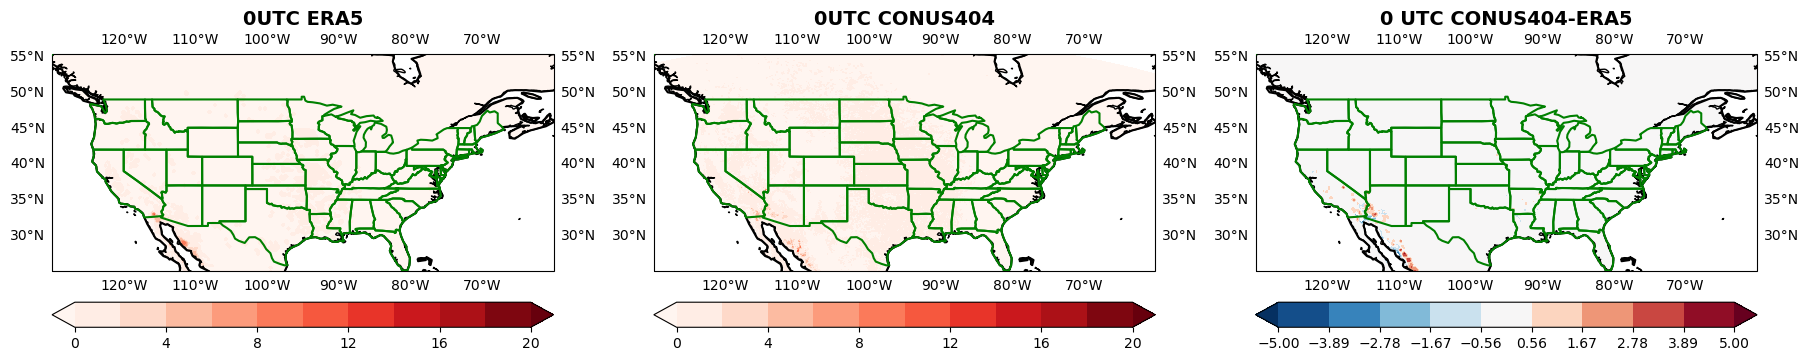

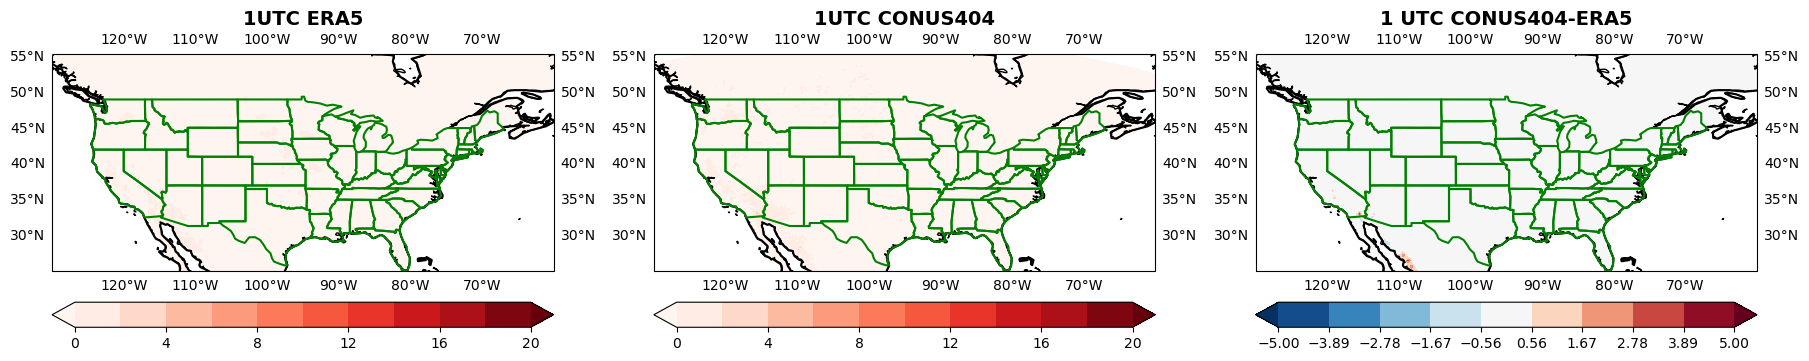

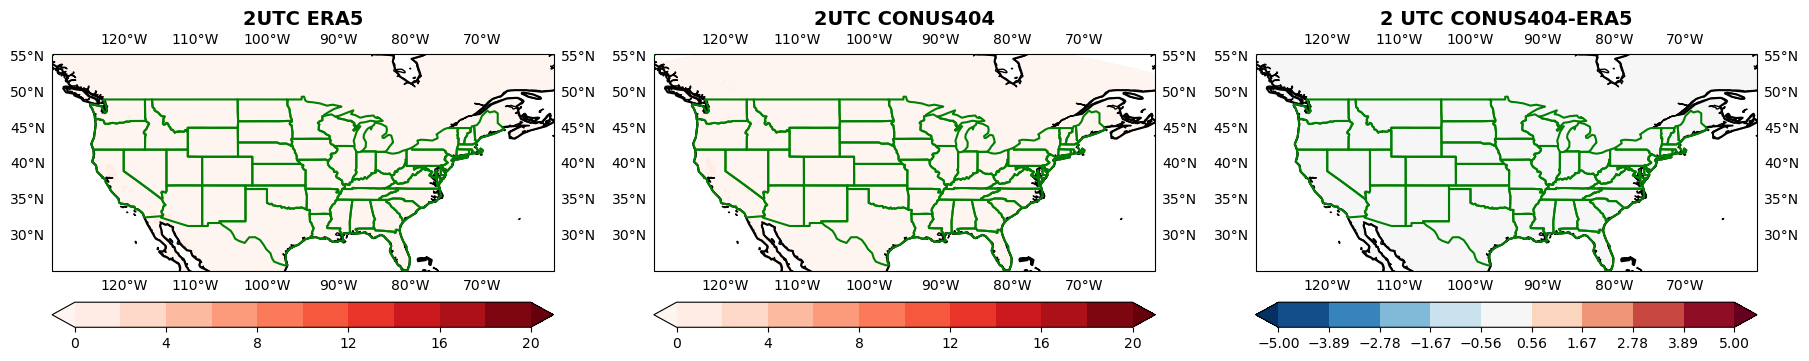

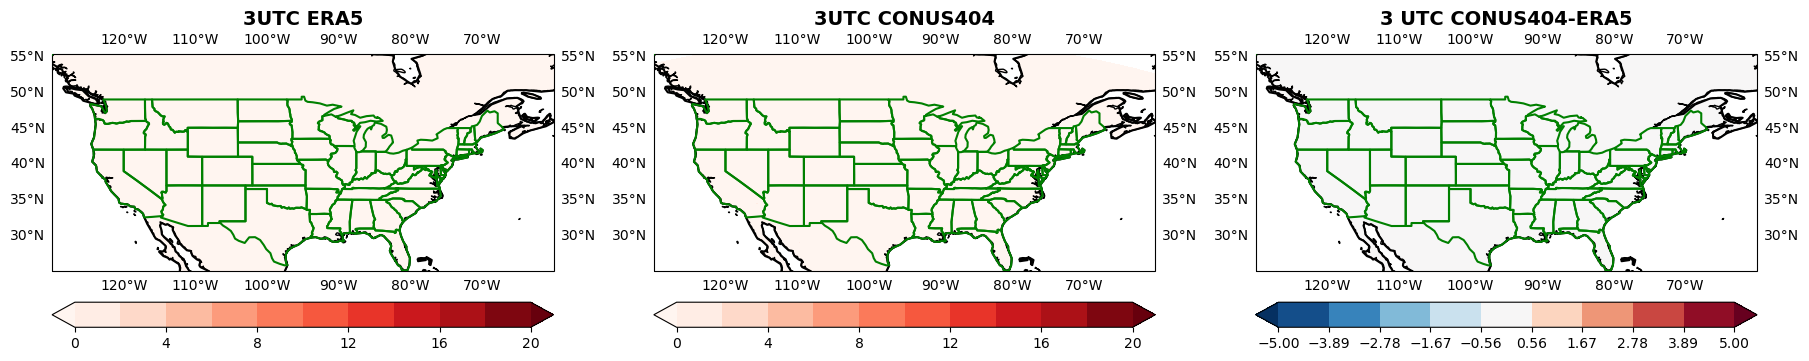

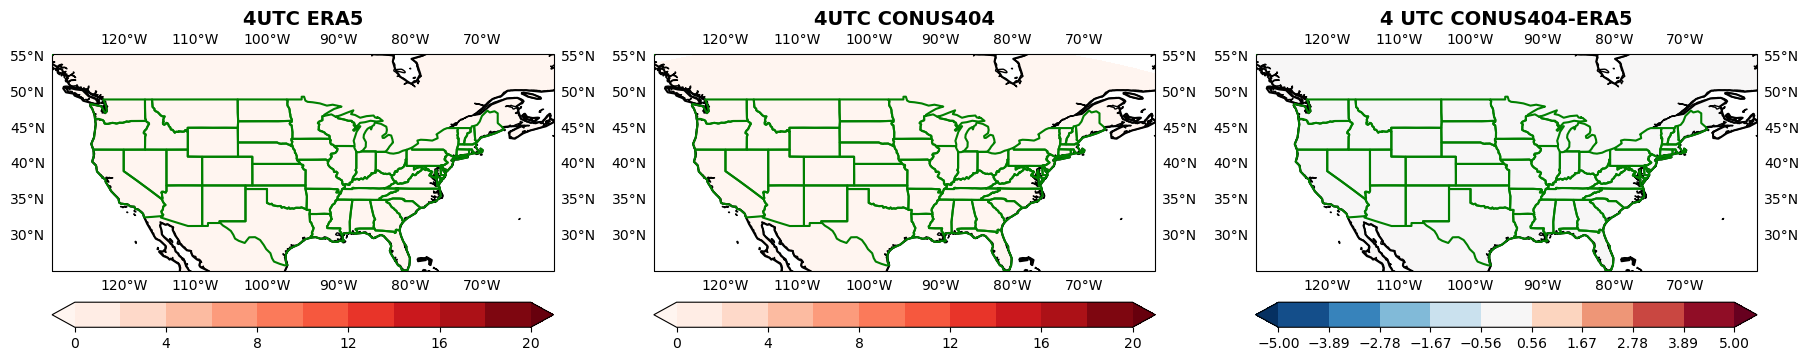

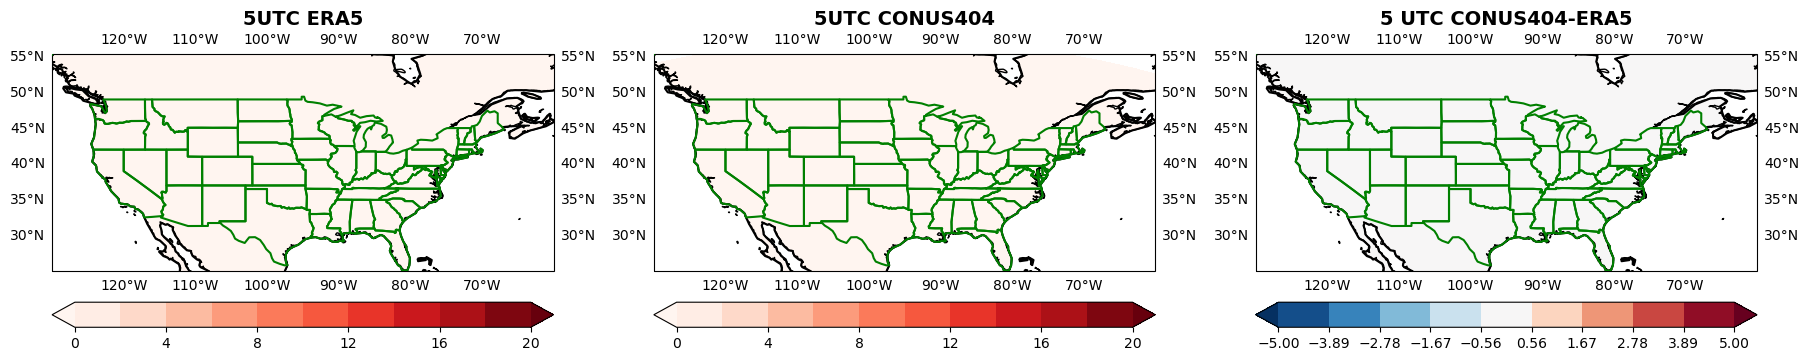

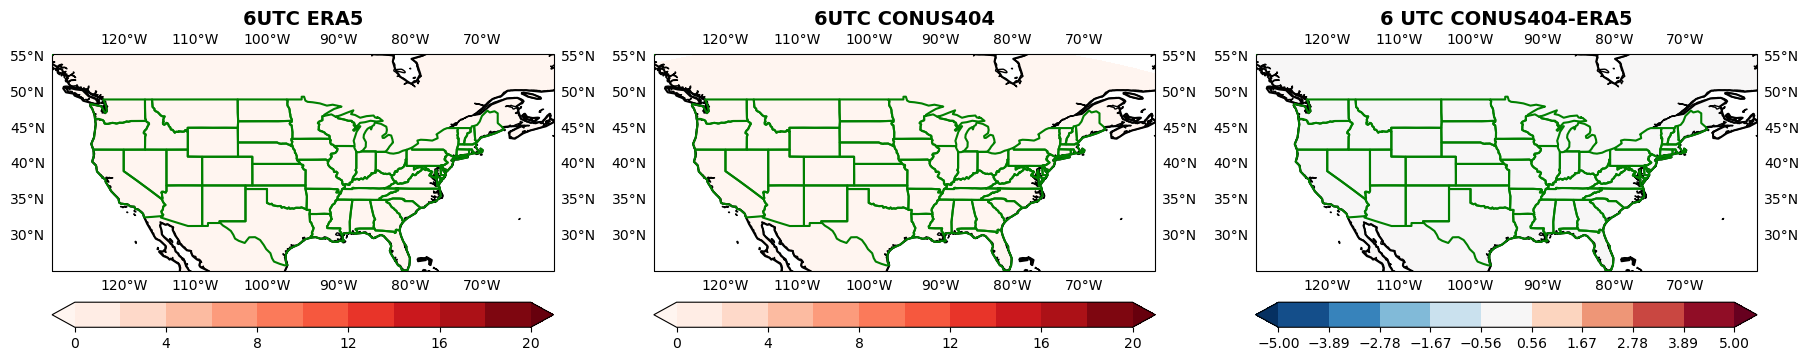

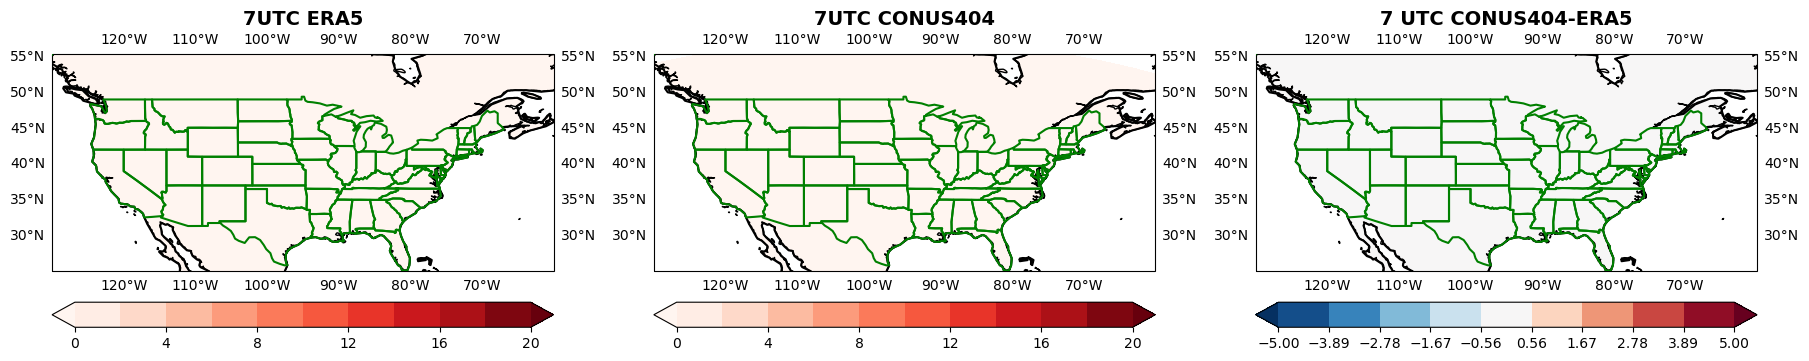

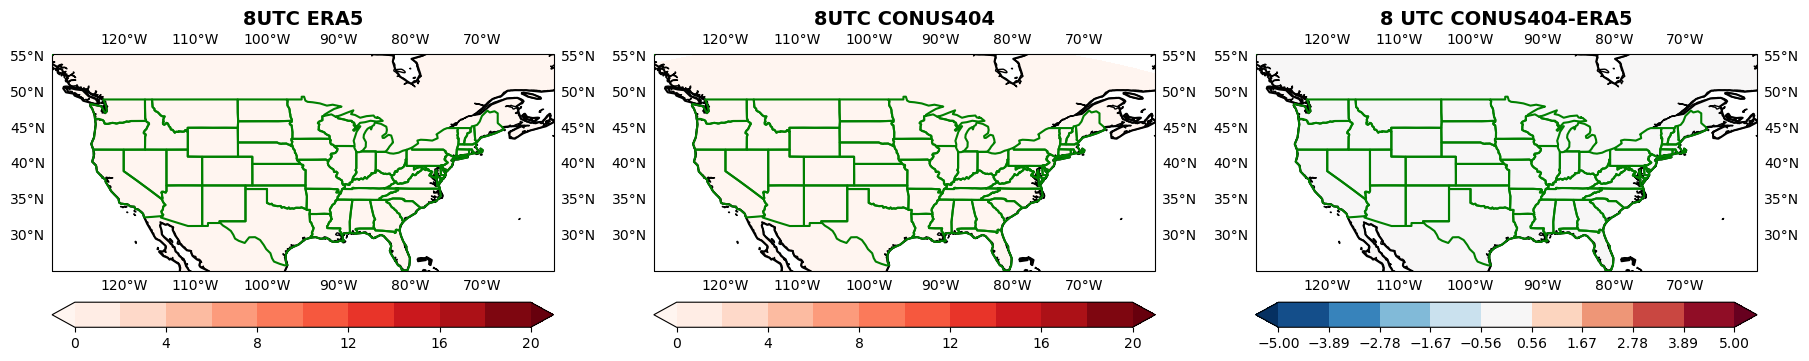

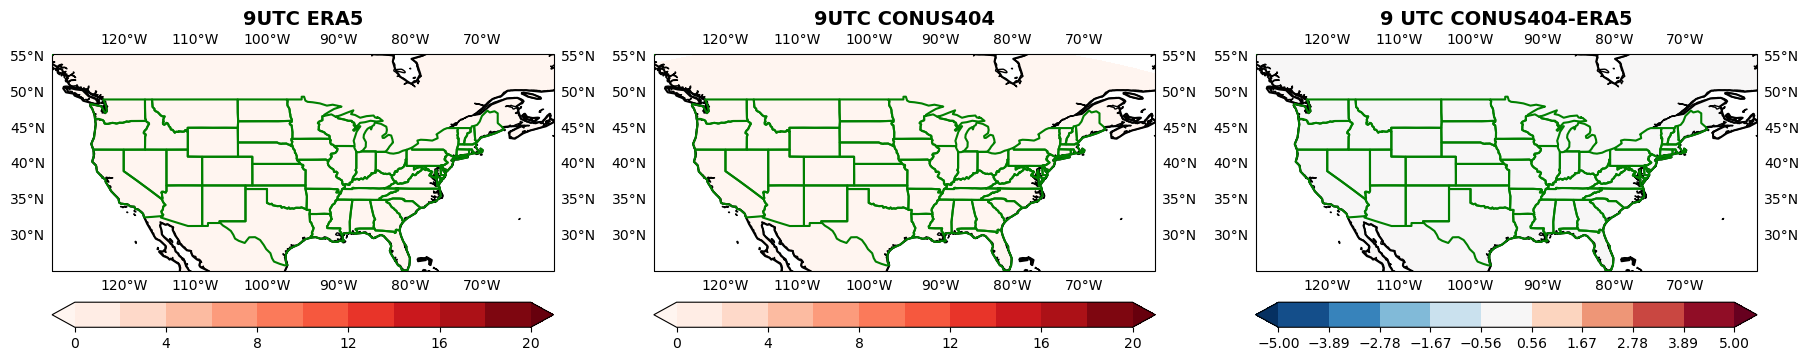

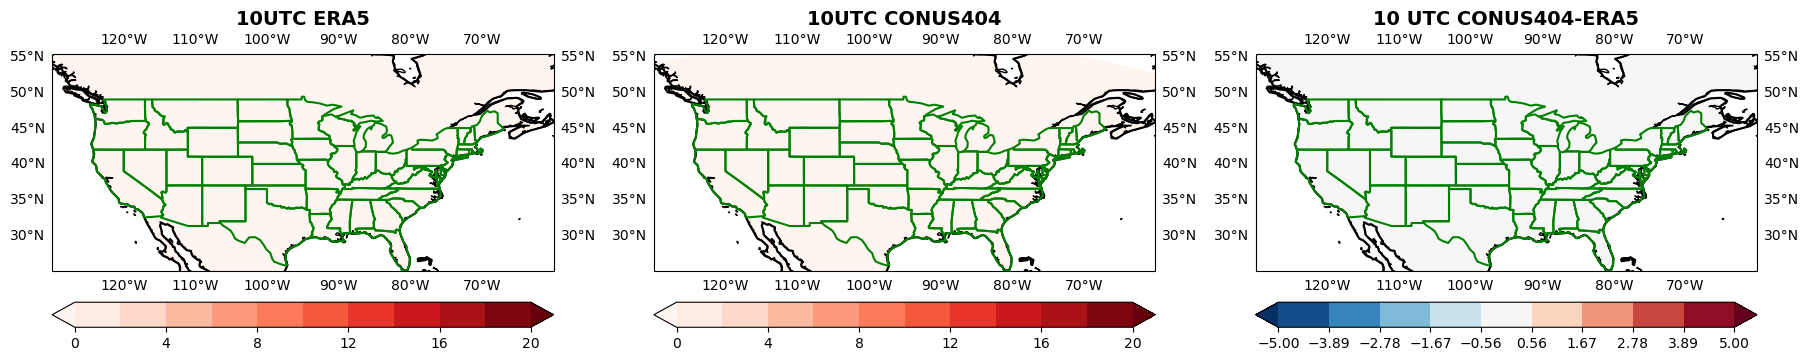

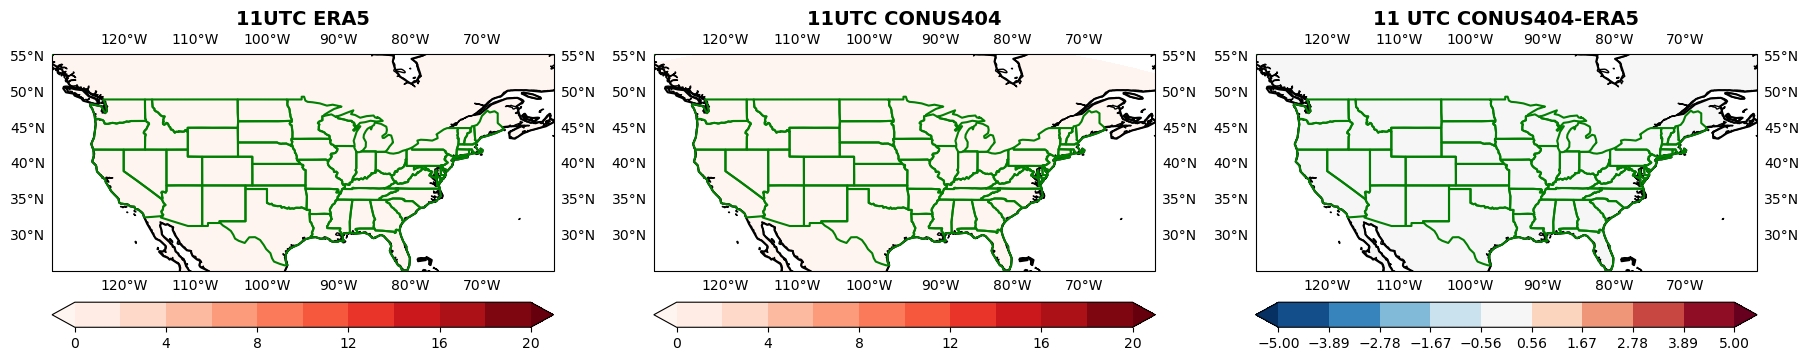

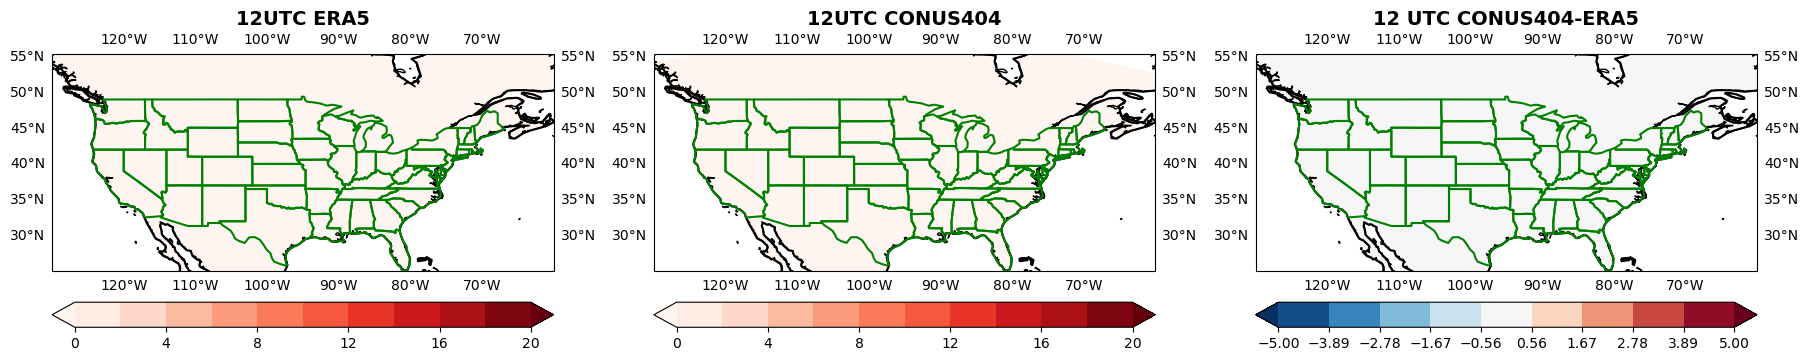

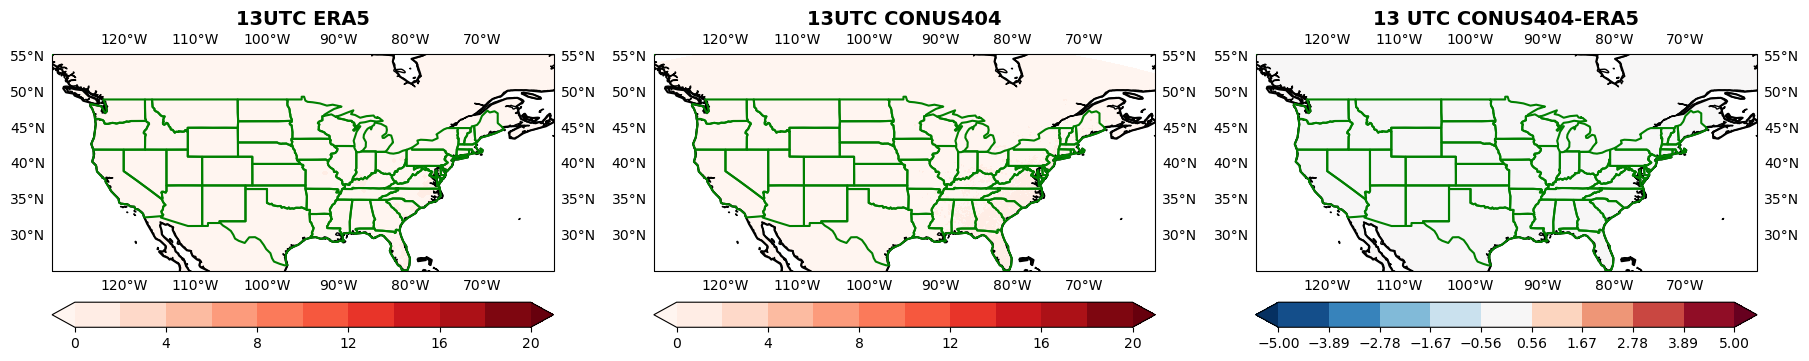

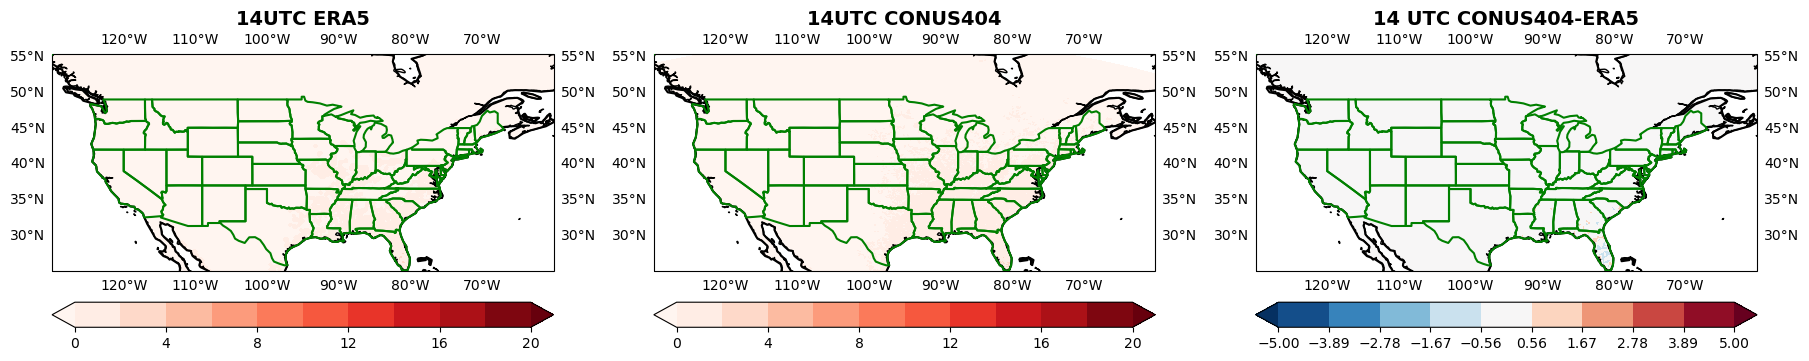

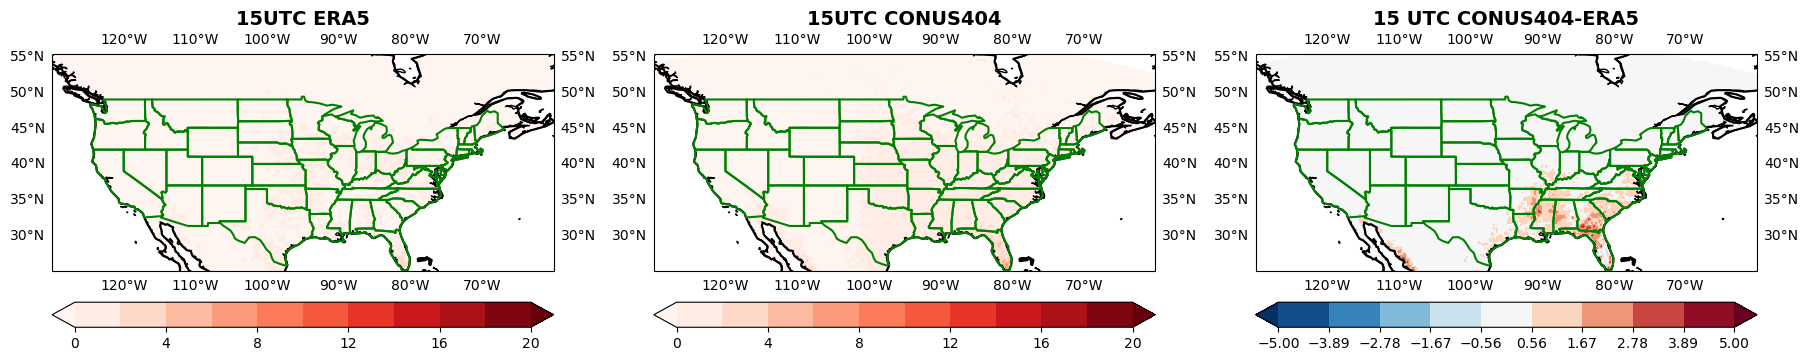

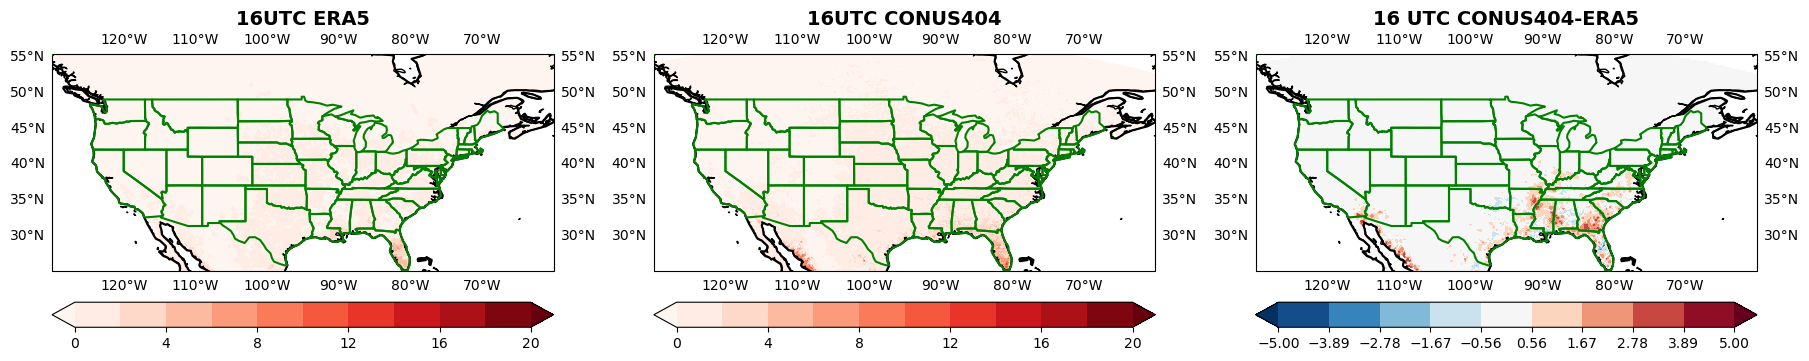

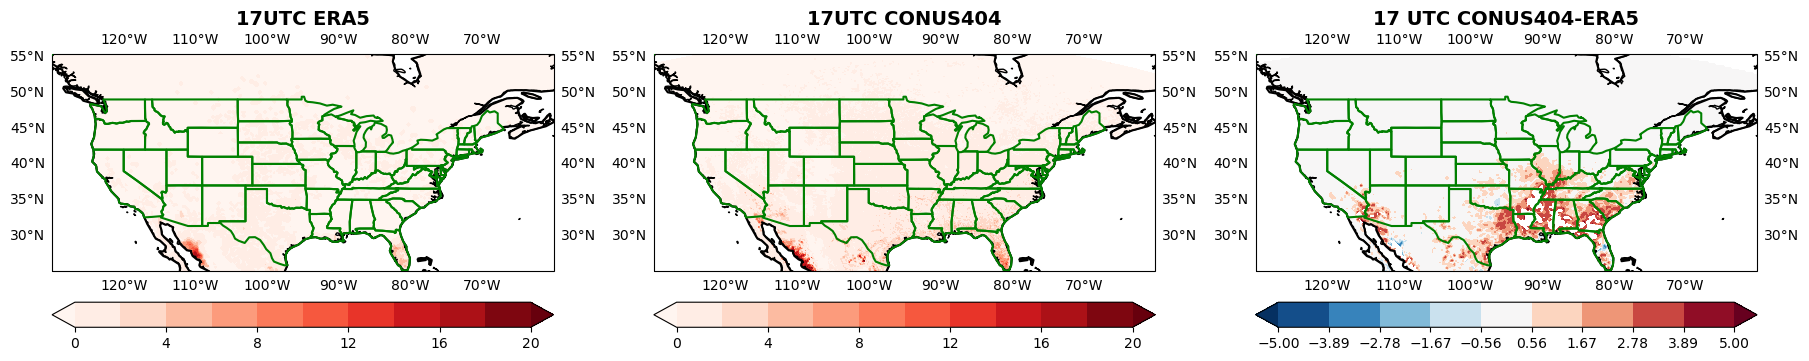

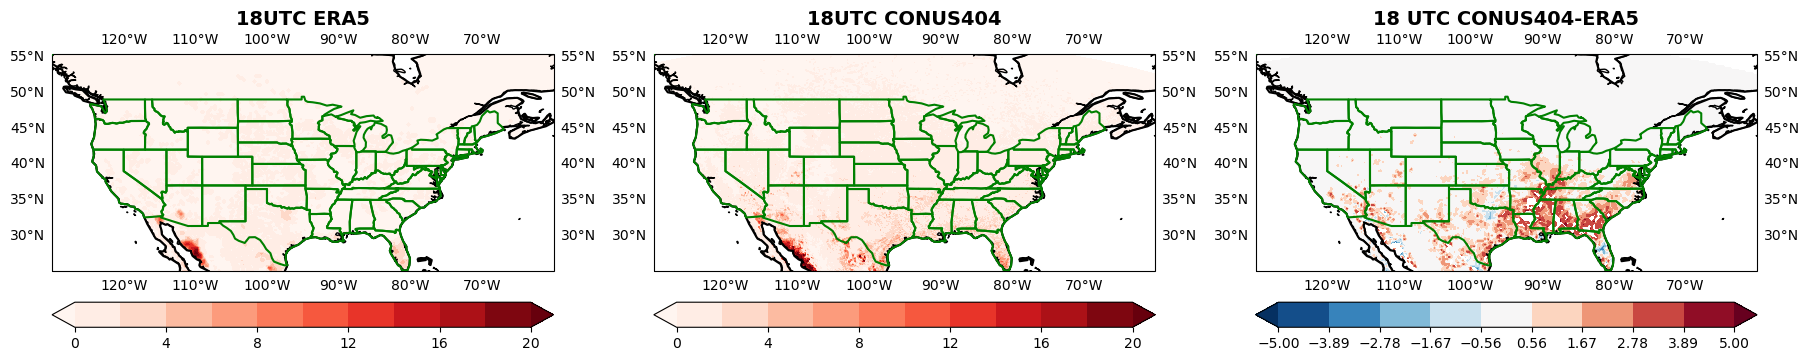

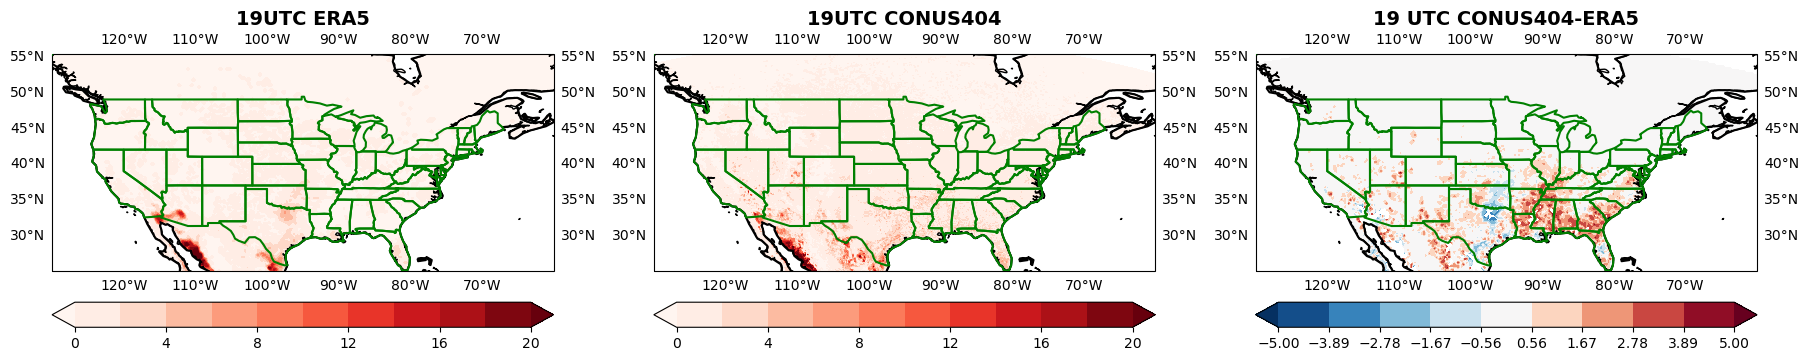

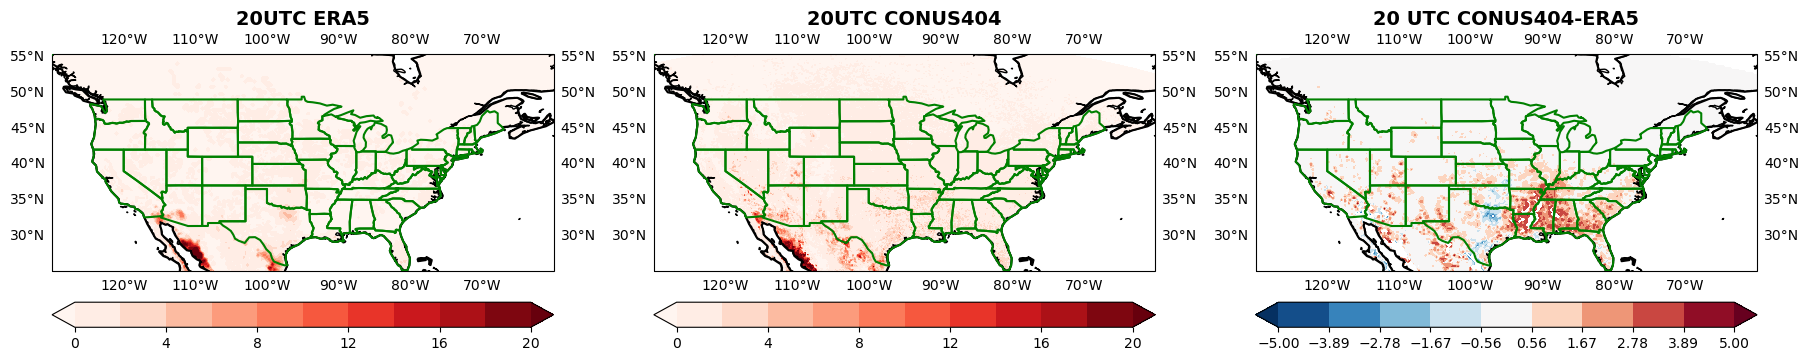

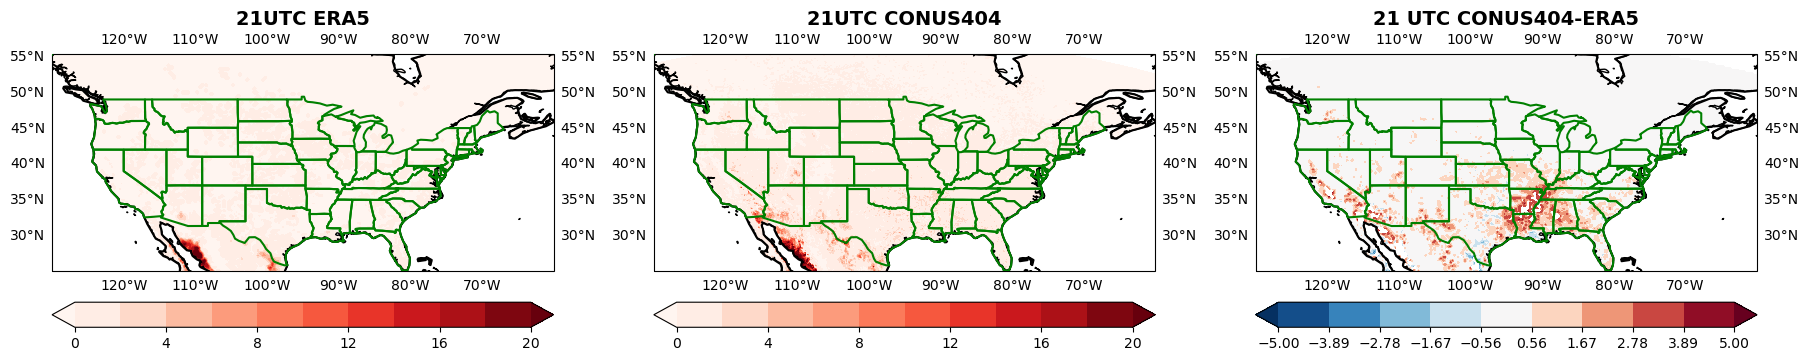

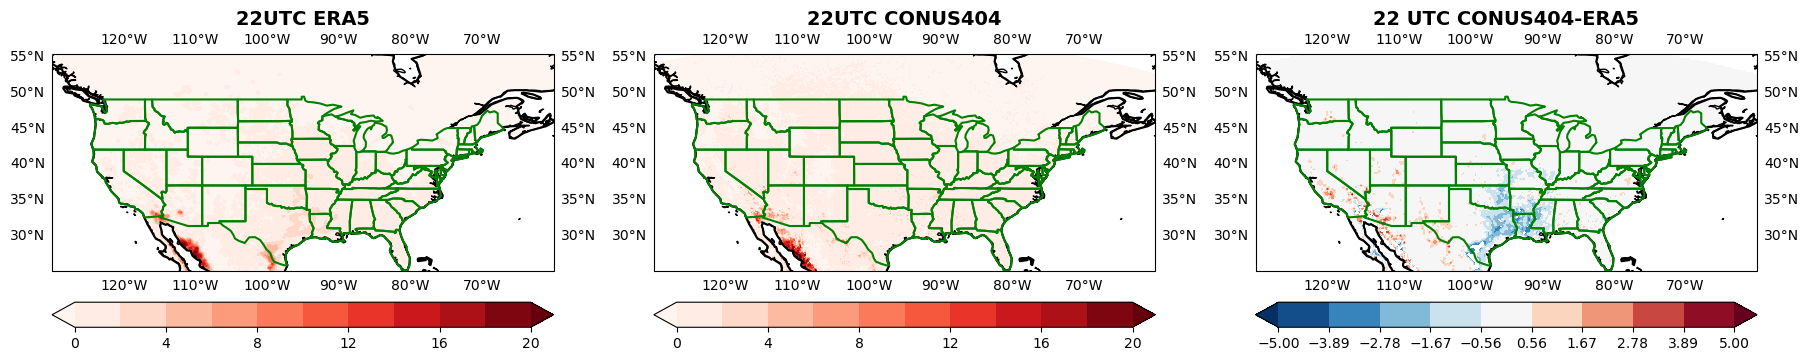

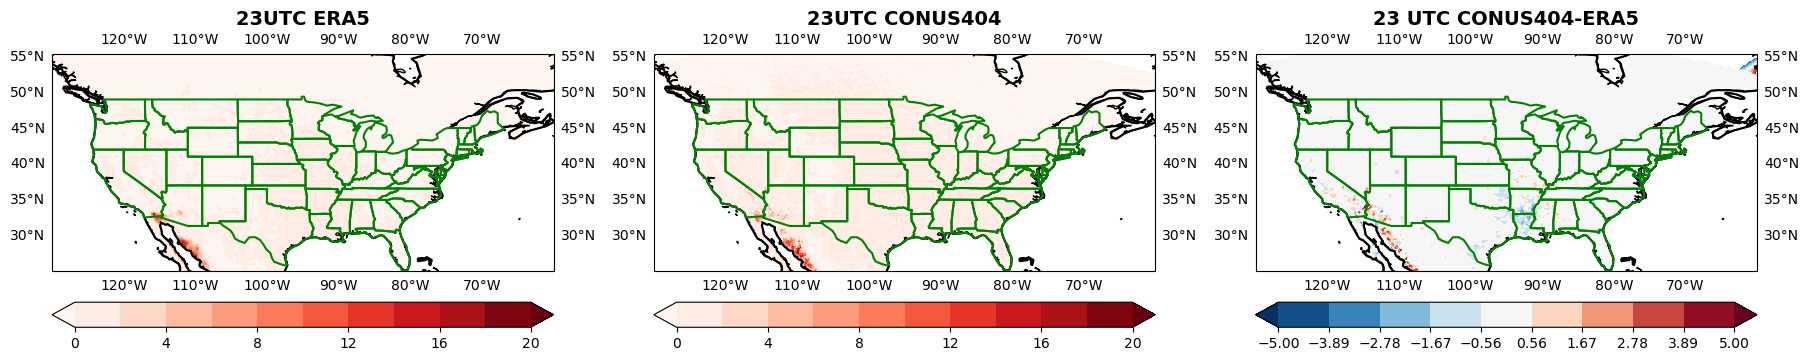

In [36]:
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'
var_s = ['WBGT', 'GWBT']
model_s = ['ERA5', 'CONUS404']
var_ss = 'n_TBF'
fig = plt.figure(figsize=(20, 8))
vmin = 0
vmax = 10
n_level = 11
levels = np.linspace(vmin, vmax, n_level) 
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}

flnm_era5 = dir_o + 'WBGT_ERA5_annual_TBFday_hourly_slope.nc'
flnm_conus = dir_o + 'GWBT_CONUS404_annual_TBFday_hourly_slope.nc'
#for nh in range(17,24):

with xr.open_dataset(flnm_era5) as ds:
    print(flnm_era5)
    #print(ds)
    da_1 = ds['polyfit_coefficients'] #[nh,0].values

with xr.open_dataset(flnm_conus) as ds:
    print(flnm_conus)
    #print(ds)
    da_2 = ds['polyfit_coefficients'] #[nh,0].values

#interpolate WRF conus to ERA5 grid
lon_2d, lat_2d = np.meshgrid(lon_era5, lat_era5)
points = np.array([lon_conus.flatten(), lat_conus.flatten()]).transpose()
vtx, wts = interp_weights(points, np.append(lon_2d.flatten()[:,None], lat_2d.flatten()[:,None], axis=1)) 

color_1d = ['Reds', 'Reds', 'RdBu_r']
for nh in range(24):
    data_1 = da_1[nh,0]*(n_year-1)
    data_2 = da_2[nh,0]*(n_year-1)
    
    valuesi=interpolate(data_2.values.flatten(), vtx, wts)
    data_3 =  valuesi.reshape(lat_2d.shape[0], lat_2d.shape[1])
    data_d = (data_3 - data_1)
    data_d = data_d.where(abs(data_d)<4)

    data_dif = xr.DataArray(data_d, 
                    coords={'latitude': lat_era5, 
                            'longitude': lon_era5},
                    dims=['latitude', 'longitude'])    

    title_1d = [str(nh)+ 'UTC ERA5', str(nh) + 'UTC CONUS404',  str(nh) + ' UTC CONUS404-ERA5']
    plot_cartopy_p3(lat_era5, lon_era5, data_1,lat_conus, lon_conus, data_2, data_dif, title_1d, 0, 20, 11, 5, color_1d)
    plt.savefig(str(nh).zfill(2) + ".png")


<img src="tbf.gif" width="1500" align="center">